# 第9章: RNN, CNN

In [3]:
# GPUメモリの使用状況の確認
!nvidia-smi

Sun May 29 04:43:23 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A6000    On   | 00000000:01:00.0 Off |                  Off |
| 30%   37C    P2    83W / 300W |   7038MiB / 48685MiB |     25%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A6000    On   | 00000000:25:00.0 Off |                  Off |
| 40%   

In [4]:
import os
# 使用するGPUを指定
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [5]:
import torch
from torch import nn
# 確認
print('device_count:', torch.cuda.device_count())
print('current device num:', torch.cuda.current_device())
# GPU
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
# device = torch.device('cpu')

device_count: 1
current device num: 0


/usr/local/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
import os
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import torch
import torch.optim as optim
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from torch import nn
from torch.utils.data import DataLoader, Dataset
from transformers import BertModel

## 80. ID番号への変換
問題51で構築した学習データ中の単語にユニークなID番号を付与したい．学習データ中で最も頻出する単語に1，2番目に頻出する単語に2，……といった方法で，学習データ中で2回以上出現する単語にID番号を付与せよ．そして，与えられた単語列に対して，ID番号の列を返す関数を実装せよ．ただし，出現頻度が2回未満の単語のID番号はすべて0とせよ．

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split

# 読み込み
df = pd.read_csv('./newsCorpora.csv', header=None, sep='\t', names=['id', 'title', 'url', 'publisher', 'category', 'story', 'hostname', 'timestamp'])

# 抽出
df = df.loc[df['publisher'].isin(['Reuters', 'Huffington Post', 'Businessweek', 'Contactmusic.com', 'Daily Mail']), ['title', 'category']]

# 分割
train, valid_test = train_test_split(df, test_size=0.2, shuffle=True, random_state=0, stratify=df['category'])
valid, test = train_test_split(valid_test, test_size=0.5, shuffle=True, random_state=0, stratify=valid_test['category'])

# 確認
print('【学習データ】')
print(train['category'].value_counts())
print('【検証データ】')
print(valid['category'].value_counts())
print('【評価データ】')
print(test['category'].value_counts())

【学習データ】
b    4502
e    4223
t    1219
m     728
Name: category, dtype: int64
【検証データ】
b    562
e    528
t    153
m     91
Name: category, dtype: int64
【評価データ】
b    563
e    528
t    152
m     91
Name: category, dtype: int64


In [8]:
from nltk import *
download('punkt')
download('wordnet')
download('averaged_perceptron_tagger')

stemmer = stem.PorterStemmer()
lemmatizer = stem.WordNetLemmatizer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [9]:
import numpy as np
import re

# 文字列の前処理
def char_processing(text):
    text = re.sub(r'[^\w\s]', ' ', text) # スペース以外の記号文字全てをスペースに置換
    text = re.sub(r'\s{2,}', ' ', text) # ２個以上のスペースは一つに置換
    return text

# 文章DFから単語DFに変換する
def make_word_df(ser):
    # 1文目
    first_text = ser.iloc[0] 
    first_text = char_processing(first_text) # 前処理
    words = [w for w in first_text.split(' ') if w != ''] # 文章を単語ごとに分割する
    words_df = pd.DataFrame(words, columns=['word'])
    # 2文目以降
    for text in ser.iloc[1:]:
        text = char_processing(text) # 前処理
        words = [w for w in text.split(' ') if w != ''] # 文章を単語ごとに分割する
        tmp = pd.DataFrame(words, columns=['word'])
        words_df = pd.concat([words_df, tmp])
    return words_df

# 単語DFから出現数をカウント。頻度上位から番号を振っていく(出現数1のものはid=0)
def word_counts(words_df):
    words_df = words_df.value_counts().reset_index()
    words_df['id'] = np.where(words_df[0] > 1, words_df.index+1, 0)
    words_df = words_df[words_df['id'] != 0]
    words_df = dict(zip(words_df['word'], words_df['id']))
    return words_df

def text_to_id(text, word_dict):
    text = char_processing(text)
    words = [w for w in text.split(' ') if w != ''] # 文章を単語ごとに分割し、文字列に変換
    word_ids = [word_dict[w] if w in word_dict.keys() else 0 for w in words] # id列に変換.辞書に登録されていないものも0にする
    return word_ids

In [10]:
# 文章DFから単語DFに変換する
train_word = make_word_df(train['title'])

In [11]:
# 単語DFから出現数をカウント。頻度上位から番号を振っていく(出現数1のものはid=0)
word_dict = word_counts(train_word)
len(word_dict)

9394

In [12]:
# 蘇生データを数値データに変換する
x_train = train['title'].map(lambda x: text_to_id(x, word_dict))
x_valid = valid['title'].map(lambda x: text_to_id(x, word_dict))
x_test = test['title'].map(lambda x: text_to_id(x, word_dict))

category_dict = {'b': 0, 'e': 1, 't':2, 'm':3}
y_train = torch.tensor(train['category'].map(lambda y: category_dict[y]).values)
y_valid = torch.tensor(valid['category'].map(lambda y: category_dict[y]).values)
y_test = torch.tensor(test['category'].map(lambda y: category_dict[y]).values)

In [13]:
# Vivendi's → Vicendi s
print('text:',train['title'].iloc[0])
print('ids:',x_train.iloc[0])

text: Bouygues confirms improved offer for Vivendi's SFR
ids: [3880, 1091, 4816, 405, 8, 6434, 2, 4410]


## 81. RNNによる予測
***
ID番号で表現された単語列$\boldsymbol{x} = (x_1, x_2, \dots, x_T)$がある．ただし，$T$は単語列の長さ，$x_t \in \mathbb{R}^{V}$は単語のID番号のone-hot表記である（$V$は単語の総数である）．再帰型ニューラルネットワーク（RNN: Recurrent Neural Network）を用い，単語列$\boldsymbol{x}$からカテゴリ$y$を予測するモデルとして，次式を実装せよ．

$
\overrightarrow h_0 = 0, \\
\overrightarrow h_t = {\rm \overrightarrow{RNN}}(\mathrm{emb}(x_t), \overrightarrow h_{t-1}), \\
y = {\rm softmax}(W^{(yh)} \overrightarrow h_T + b^{(y)})
$

ただし，$\mathrm{emb}(x) \in \mathbb{R}^{d_w}$は単語埋め込み（単語のone-hot表記から単語ベクトルに変換する関数），$\overrightarrow h_t \in \mathbb{R}^{d_h}$は時刻$t$の隠れ状態ベクトル，${\rm \overrightarrow{RNN}}(x,h)$は入力$x$と前時刻の隠れ状態$h$から次状態を計算するRNNユニット，$W^{(yh)} \in \mathbb{R}^{L \times d_h}$は隠れ状態ベクトルからカテゴリを予測するための行列，$b^{(y)} \in \mathbb{R}^{L}$はバイアス項である（$d_w, d_h, L$はそれぞれ，単語埋め込みの次元数，隠れ状態ベクトルの次元数，ラベル数である）．RNNユニット${\rm \overrightarrow{RNN}}(x,h)$には様々な構成が考えられるが，典型例として次式が挙げられる．

$
{\rm \overrightarrow{RNN}}(x,h) = g(W^{(hx)} x + W^{(hh)}h + b^{(h)})
$

ただし，$W^{(hx)} \in \mathbb{R}^{d_h \times d_w}，W^{(hh)} \in \mathbb{R}^{d_h \times d_h}, b^{(h)} \in \mathbb{R}^{d_h}$はRNNユニットのパラメータ，$g$は活性化関数（例えば$\tanh$やReLUなど）である．

なお，この問題ではパラメータの学習を行わず，ランダムに初期化されたパラメータで$y$を計算するだけでよい．次元数などのハイパーパラメータは，$d_w = 300, d_h=50$など，適当な値に設定せよ（以降の問題でも同様である）．

nn.Embedding(vocab_size, emb_dim, padding_idx=padding_idx) 
単語IDを指定した次元のベクトルに埋め込む
padding_idx=単語列の長さを揃えるための値

In [14]:
from torch.utils.data import TensorDataset, DataLoader, Dataset
class RNN(nn.Module):
    def __init__(self, vocab_size, emb_dim=300, hidden_size=50, batch_size=1, output_size=4,padding_idx=0):
        super().__init__()
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=padding_idx) # 1層：Embedding層 id=0は計算しない
        self.rnn = nn.RNN(input_size=emb_dim, hidden_size=hidden_size, num_layers=1, nonlinearity="tanh", bias=True, batch_first=True) # 2層：RNN
        self.fc = nn.Linear(hidden_size, output_size, bias=True) # ３層：全結合層
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x, h0=None):
        h0 = torch.zeros(1, self.batch_size, self.hidden_size)
        x = self.emb(x)           # 0 to 1層
        x, h_t = self.rnn(x, h0)  # 1 to 2層
        x = x[:, -1, :]           # 一番最後の単語ベクトルの出力
        x = self.fc(x)            # 2 to 3層
        x = self.softmax(x)       # 3 to out
        return x

vocab_size = len(word_dict.keys())+1 # 辞書のID数 + パディングID
padding_idx = len(word_dict.keys()) # 最終番号をパディング値とする

# modelの定義
model = RNN(vocab_size=vocab_size,padding_idx=padding_idx)

# 先頭10件の予測値取得
for i in range(10):
    inputs = torch.tensor(x_train.iloc[i])
    print(torch.softmax(model(inputs.unsqueeze(0)), dim=-1))

tensor([[0.2437, 0.2345, 0.2618, 0.2599]], grad_fn=<SoftmaxBackward>)
tensor([[0.2488, 0.2199, 0.3217, 0.2096]], grad_fn=<SoftmaxBackward>)
tensor([[0.2274, 0.2430, 0.2512, 0.2785]], grad_fn=<SoftmaxBackward>)
tensor([[0.2391, 0.2345, 0.2915, 0.2349]], grad_fn=<SoftmaxBackward>)
tensor([[0.2510, 0.2649, 0.2320, 0.2521]], grad_fn=<SoftmaxBackward>)
tensor([[0.2572, 0.2718, 0.2560, 0.2151]], grad_fn=<SoftmaxBackward>)
tensor([[0.2535, 0.2693, 0.2412, 0.2360]], grad_fn=<SoftmaxBackward>)
tensor([[0.2500, 0.2165, 0.2501, 0.2834]], grad_fn=<SoftmaxBackward>)
tensor([[0.2363, 0.2284, 0.2685, 0.2668]], grad_fn=<SoftmaxBackward>)
tensor([[0.2487, 0.2337, 0.2409, 0.2766]], grad_fn=<SoftmaxBackward>)


## 82. 確率的勾配降下法による学習
***
確率的勾配降下法（SGD: Stochastic Gradient Descent）を用いて，問題81で構築したモデルを学習せよ．訓練データ上の損失と正解率，評価データ上の損失と正解率を表示しながらモデルを学習し，適当な基準（例えば10エポックなど）で終了させよ．

In [15]:
from IPython.display import clear_output
from matplotlib import pyplot as plt
%matplotlib inline
# データ更新があるたびにグラフを更新する関数
def live_plot(train_losses, train_accuracies, valid_losses, valid_accuracies):
    # グラフ準備
    clear_output(wait=True)
    fig, ax = plt.subplots(1,2,figsize=(14,5))
    # 損失をplot
    ax[0].plot(train_losses,c='blue', label='train')
    ax[0].plot(valid_losses,c='green', label='vaid')
    ax[0].set_title('loss')
    ax[0].legend()
    # 正解率をplot
    ax[1].plot(train_accuracies,c='blue', label='train')
    ax[1].plot(valid_accuracies,c='green', label='vaid')
    ax[1].set_title('accuracy')
    ax[1].legend()
    plt.show()

[Dataset公式リファレンス](https://pytorch.org/docs/stable/_modules/torch/utils/data/dataset.html#TensorDataset)
__getitem__をoverwriteすることで、Dataset[index]で返す値を指定できる

In [16]:
from torch.utils.data import Dataset, DataLoader

# TensorDatasetだと、単語ID列の長さが一致しないとダメなので自作する
class CreateDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):  # len(Dataset)で返す値を指定
        return len(self.y)

    def __getitem__(self, index):  # Dataset[index]で返す値を指定
        return {
          'inputs': torch.tensor(self.x.iloc[index], dtype=torch.int64),
          'labels': torch.tensor(self.y[index], dtype=torch.int64)
        }
# Datasetの作成
train_dataset = CreateDataset(x_train, y_train)
valid_dataset = CreateDataset(x_valid, y_valid)
test_dataset = CreateDataset(x_test, y_test)

In [17]:
def loss_and_accuracy(model, dataset, device=None, criterion=None):
  dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
  loss = 0.0
  total = 0
  correct = 0
  model.eval()
  with torch.no_grad():
    for data in dataloader:
      # デバイスの指定
      inputs = data['inputs'].to(device)
      labels = data['labels'].to(device)

      # 順伝播
      outputs = model(inputs)

      # 損失計算
      if criterion != None:
        loss += criterion(outputs, labels).item()

      # 正解率計算
      pred = torch.argmax(outputs, dim=-1)
      total += len(inputs)
      correct += (pred == labels).sum().item()

  return loss / len(dataset), correct / total

|RNN 引数|説明|
|:--:|:--|
|num_layers|Number of recurrent layers. E.g., setting num_layers=2 would mean stacking two RNNs together to form a stacked RNN, with the second RNN taking in outputs of the first RNN and computing the final results. Default: 1|
|bidirectional| If True, becomes a bidirectional RNN. Default: False|


|Embedding 引数|説明|
|:--:|:--|
|num_embeddings| (int) – size of the dictionary of embeddings|
|embedding_dim |(int) – the size of each embedding vector|
|padding_idx |(int, optional) – If specified, the entries at padding_idx do not contribute to the gradient; therefore, the embedding vector at padding_idx is not updated during training, i.e. it remains as a fixed “pad”. For a newly constructed Embedding, the embedding vector at padding_idx will default to all zeros, but can be updated to another value to be used as the padding vector.|
|max_norm| (float, optional) – If given, each embedding vector with norm larger than max_norm is renormalized to have norm max_norm.|
|norm_type |(float, optional) – The p of the p-norm to compute for the max_norm option. Default 2.|
|scale_grad_by_freq| (boolean, optional) – If given, this will scale gradients by the inverse of frequency of the words in the mini-batch. Default False.|
|sparse| (bool, optional) – If True, gradient w.r.t. weight matrix will be a sparse tensor. See Notes for more details regarding sparse gradients.|

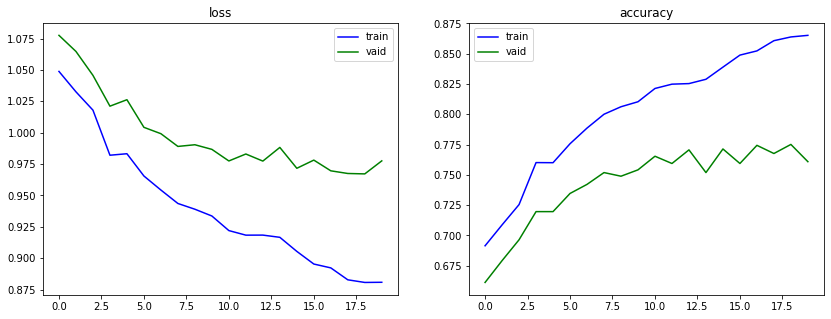

In [91]:
from torch.utils.data import TensorDataset, DataLoader, Dataset
class RNN(nn.Module):
    def __init__(self, vocab_size, emb_dim=300, hidden_size=50, batch_size=1, output_size=4,padding_idx=0):
        super().__init__()
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=padding_idx) # 1層：Embedding層 id=0は計算しない
        self.rnn = nn.RNN(input_size=emb_dim, hidden_size=hidden_size, num_layers=1, nonlinearity="tanh", bias=True, batch_first=True) # 2層：RNN
        self.fc = nn.Linear(hidden_size, output_size, bias=True) # ３層：全結合層
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x, h0=None):
        h0 = torch.zeros(1, self.batch_size, self.hidden_size).to(device)
        x = self.emb(x)           # 0 to 1層
        x, h_t = self.rnn(x, h0)  # 1 to 2層
        x = x[:, -1, :]           # 一番最後の単語ベクトルの出力
        x = self.fc(x)            # 2 to 3層
        x = self.softmax(x)       # 3 to out
        return x

vocab_size = len(word_dict.keys())+1 # 辞書のID数 + パディングID
padding_idx = len(word_dict.keys()) # 最終番号をパディング値とする

# modelの定義
model = RNN(vocab_size=vocab_size,padding_idx=padding_idx).to(device)
# 損失関数
criterion = nn.CrossEntropyLoss()
# オプティマイザ
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

train_losses = [] # 学習データの損失
train_accuracies = [] # 学習データの正解率
valid_losses = [] # 検証データの損失
valid_accuracies = [] # 検証データの正解率


for epoch in range(20):
    for data in loader:
        # デバイスの指定
        inputs = data['inputs'].to(device)
        labels = data['labels'].to(device)
        # forward
        model.train()
        outputs = model(inputs.to(device))
        # 損失
        loss = criterion(outputs, labels).to(device)
        # 勾配
        optimizer.zero_grad()
        loss.backward()
        # 更新
        optimizer.step()

    # 学習の進捗
    train_loss, train_accuracy = loss_and_accuracy(model, train_dataset, device, criterion=criterion)
    valid_loss, valid_accuracy = loss_and_accuracy(model, valid_dataset, device, criterion=criterion)

    # 保存
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_accuracy)

    # グラフの描画
    live_plot(train_losses, train_accuracies, valid_losses, valid_accuracies)

## 83. ミニバッチ化・GPU上での学習
***
問題82のコードを改変し，$B$事例ごとに損失・勾配を計算して学習を行えるようにせよ（$B$の値は適当に選べ）．また，GPU上で学習を実行せよ．

バッチサイズ：1回の更新を行うときに使うデータの数。大きいほど全体が考慮され、小さいほど部分的なものに対しても学習される
また、バッチサイズが大きいと更新が少ないため学習が高速化する

In [22]:
from torch.utils.data import Dataset, DataLoader

# TensorDatasetだと、単語ID列の長さが一致しないとダメなので自作する
class CreateDataset_with_padding(Dataset):
    def __init__(self, x, y, padding_idx):
        self.x = x
        self.y = y
        self.padding_idx = padding_idx
        self.max_len = max([len(li) for li in x])

    def __len__(self):  # len(Dataset)で返す値を指定
        return len(self.y)

    def __getitem__(self, index):  # Dataset[index]で返す値を指定
        inputs = self.x.iloc[index]
        for i in range(self.max_len - len(inputs)):
            inputs.append(self.padding_idx)
        return {
          'inputs': torch.tensor(inputs, dtype=torch.int64),
          'labels': torch.tensor(self.y[index], dtype=torch.int64)
        }
# Datasetの作成
train_dataset = CreateDataset_with_padding(x_train, y_train, padding_idx)
valid_dataset = CreateDataset_with_padding(x_valid, y_valid, padding_idx)

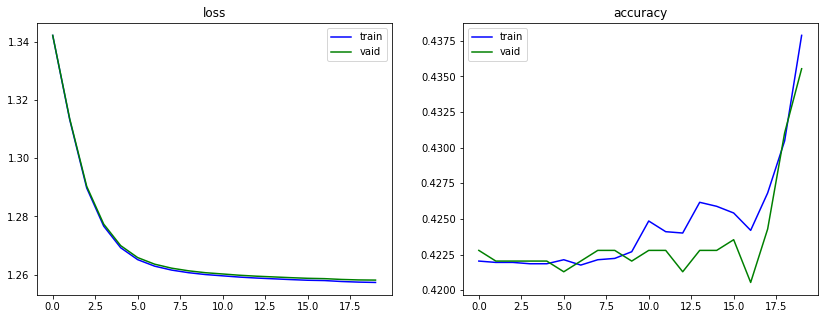

In [18]:
from torch.utils.data import TensorDataset, DataLoader, Dataset
class RNN(nn.Module):
    def __init__(self, vocab_size, emb_dim=300, hidden_size=50, batch_size=1, output_size=4,padding_idx=0):
        super().__init__()
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=padding_idx) # 1層：Embedding層 id=0は計算しない
        self.rnn = nn.RNN(input_size=emb_dim, hidden_size=hidden_size, num_layers=1, nonlinearity="tanh", bias=True, batch_first=True) # 2層：RNN
        self.fc = nn.Linear(hidden_size, output_size, bias=True) # ３層：全結合層
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        h0 = torch.zeros(1, x.size()[0], self.hidden_size).to(device)
        x = self.emb(x)           # 0 to 1層
        x, h_t = self.rnn(x, h0)  # 1 to 2層
        x = x[:, -1, :]           # 一番最後の単語ベクトルの出力
        x = self.fc(x)            # 2 to 3層
        x = self.softmax(x)       # 3 to out
        return x

vocab_size = len(word_dict.keys())+1 # 辞書のID数 + パディングID
padding_idx = len(word_dict.keys()) # 最終番号をパディング値とする

# modelの定義
model = RNN(vocab_size=vocab_size, batch_size=32, padding_idx=padding_idx).to(device)
# 損失関数
criterion = nn.CrossEntropyLoss()
# オプティマイザ
optimizer = torch.optim.SGD(model.parameters(), lr=0.005)

loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

train_losses = [] # 学習データの損失
train_accuracies = [] # 学習データの正解率
valid_losses = [] # 検証データの損失
valid_accuracies = [] # 検証データの正解率


for epoch in range(20):
    for data in loader:
        # デバイスの指定
        inputs = data['inputs'].to(device)
        labels = data['labels'].to(device)
        # forward
        model.train()
        outputs = model(inputs.to(device))
        # 損失
        loss = criterion(outputs, labels).to(device)
        # 勾配
        optimizer.zero_grad()
        loss.backward()
        # 更新
        optimizer.step()

    # 学習の進捗
    train_loss, train_accuracy = loss_and_accuracy(model, train_dataset, device, criterion=criterion)
    valid_loss, valid_accuracy = loss_and_accuracy(model, valid_dataset, device, criterion=criterion)

    # 保存
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_accuracy)

    # グラフの描画
    live_plot(train_losses, train_accuracies, valid_losses, valid_accuracies)

## 84. 単語ベクトルの導入
***
事前学習済みの単語ベクトル（例えば，Google Newsデータセット（約1,000億単語）での学習済み単語ベクトル）で単語埋め込み$emb(x)$を初期化し，学習せよ．

In [20]:
from gensim.models import KeyedVectors
wordmodel = KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin.gz', binary=True)

In [21]:
# 各単語の見出し語を返す
def lemma(word):
    pos = [pos for word, pos in pos_tag(word_tokenize(word))][0]
    if pos.startswith('J'): # 形容詞
        return lemmatizer.lemmatize(word, pos="a")
    elif pos.startswith('V'): # 動詞
        return lemmatizer.lemmatize(word, pos="v")
    elif pos.startswith('N'): # 名詞
        return lemmatizer.lemmatize(word, pos="n")
    elif pos.startswith('R'): # 副詞
        return lemmatizer.lemmatize(word, pos="r")
    else:
        return word

In [22]:
emb_weights = torch.zeros(vocab_size, 300) 
words_in_model= 0
for word, idx in word_dict.items():
    if word in wordmodel.index_to_key:
        emb_weights[idx] = torch.tensor(wordmodel[word])
        words_in_model += 1
    elif lemma(word) in wordmodel.index_to_key:
        emb_weights[idx] = torch.tensor(wordmodel[lemma(word)])
        words_in_model += 1
        
print(f'学習済みベクトル利用単語数: {words_in_model} / {vocab_size}')

学習済みベクトル利用単語数: 9174 / 9395


In [ ]:
# Datasetの作成
train_dataset = CreateDataset(x_train, y_train)

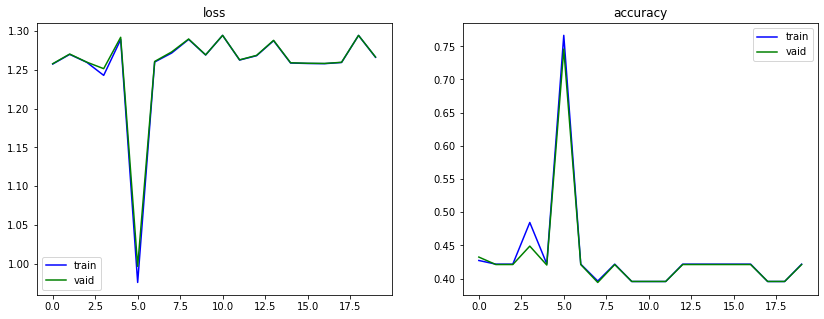

In [23]:
from torch.utils.data import TensorDataset, DataLoader, Dataset

class RNN(nn.Module):
    def __init__(self, vocab_size, emb_dim=300, hidden_size=50, batch_size=1, output_size=4,padding_idx=0):
        super().__init__()
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.emb = nn.Embedding.from_pretrained(emb_weights, padding_idx=padding_idx) # 1層：Embedding層 id=0は計算しない
        self.rnn = nn.RNN(input_size=emb_dim, hidden_size=hidden_size, num_layers=1, nonlinearity="tanh", bias=True, batch_first=True) # 2層：RNN
        self.fc = nn.Linear(hidden_size, output_size, bias=True) # ３層：全結合層
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x, h0=None):
        h0 = torch.zeros(1, self.batch_size, self.hidden_size).to(device)
        x = self.emb(x)           # 0 to 1層
        x, h_t = self.rnn(x, h0)  # 1 to 2層
        x = x[:, -1, :]           # 一番最後の単語ベクトルの出力
        x = self.fc(x)            # 2 to 3層
        x = self.softmax(x)       # 3 to out
        return x

vocab_size = len(word_dict.keys())+1 # 辞書のID数 + パディングID
padding_idx = len(word_dict.keys()) # 最終番号をパディング値とする

# modelの定義
model = RNN(vocab_size=vocab_size,padding_idx=padding_idx).to(device)
# 損失関数
criterion = nn.CrossEntropyLoss()
# オプティマイザ
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

train_losses = [] # 学習データの損失
train_accuracies = [] # 学習データの正解率
valid_losses = [] # 検証データの損失
valid_accuracies = [] # 検証データの正解率


for epoch in range(20):
    for data in loader:
        # デバイスの指定
        inputs = data['inputs'].to(device)
        labels = data['labels'].to(device)
        # forward
        model.train()
        outputs = model(inputs.to(device))
        # 損失
        loss = criterion(outputs, labels).to(device)
        # 勾配
        optimizer.zero_grad()
        loss.backward()
        # 更新
        optimizer.step()

    # 学習の進捗
    train_loss, train_accuracy = loss_and_accuracy(model, train_dataset, device, criterion=criterion)
    valid_loss, valid_accuracy = loss_and_accuracy(model, valid_dataset, device, criterion=criterion)

    # 保存
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_accuracy)

    # グラフの描画
    live_plot(train_losses, train_accuracies, valid_losses, valid_accuracies)

## 85. 双方向RNN・多層化
***
順方向と逆方向のRNNの両方を用いて入力テキストをエンコードし，モデルを学習せよ．

$
\overleftarrow h_{T+1} = 0, \\
\overleftarrow h_t = {\rm \overleftarrow{RNN}}(\mathrm{emb}(x_t), \overleftarrow h_{t+1}), \\
y = {\rm softmax}(W^{(yh)} [\overrightarrow h_T; \overleftarrow h_1] + b^{(y)})
$

ただし，$\overrightarrow h_t \in \mathbb{R}^{d_h}, \overleftarrow h_t \in \mathbb{R}^{d_h}$はそれぞれ，順方向および逆方向のRNNで求めた時刻$t$の隠れ状態ベクトル，${\rm \overleftarrow{RNN}}(x,h)$は入力$x$と次時刻の隠れ状態$h$から前状態を計算するRNNユニット，$W^{(yh)} \in \mathbb{R}^{L \times 2d_h}$は隠れ状態ベクトルからカテゴリを予測するための行列，$b^{(y)} \in \mathbb{R}^{L}$はバイアス項である．また，$[a; b]$はベクトル$a$と$b$の連結を表す。

さらに，双方向RNNを多層化して実験せよ．

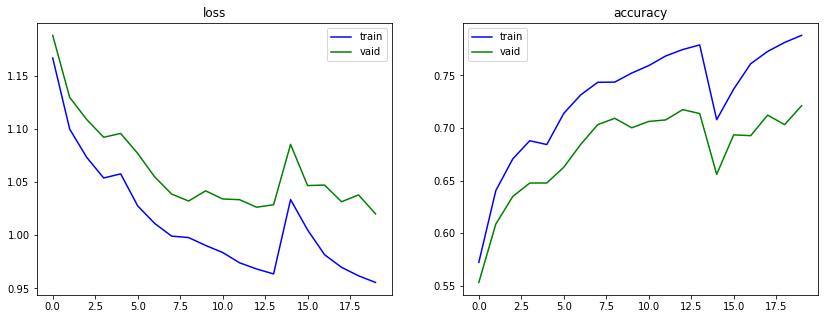

In [21]:
class RNN(nn.Module):
    def __init__(self, vocab_size, emb_dim=300, hidden_size=50, batch_size=1, num_layers=1,bidirectional=1, output_size=4,padding_idx=0):
        super().__init__()
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=padding_idx) # 1層：Embedding層 id=0は計算しない
        self.rnn = nn.RNN(input_size=emb_dim, hidden_size=hidden_size, num_layers=num_layers, bidirectional=True, nonlinearity="tanh", bias=True, batch_first=True) # 2層：RNN
        self.fc = nn.Linear(hidden_size*bidirectional, output_size, bias=True) # ３層：全結合層
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers*self.bidirectional, self.batch_size, self.hidden_size).to(device)
        x = self.emb(x)           # 0 to 1層
        x, h_t = self.rnn(x, h0)  # 1 to 2層
        x = x[:, -1, :]           # 一番最後の単語ベクトルの出力
        x = self.fc(x)            # 2 to 3層
        x = self.softmax(x)       # 3 to out
        return x

# modelの定義
model = RNN(vocab_size=vocab_size,num_layers=2,bidirectional=2, padding_idx=padding_idx).to(device)
# 損失関数
criterion = nn.CrossEntropyLoss()
# オプティマイザ
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

train_losses = [] # 学習データの損失
train_accuracies = [] # 学習データの正解率
valid_losses = [] # 検証データの損失
valid_accuracies = [] # 検証データの正解率


for epoch in range(20):
    for data in loader:
        # デバイスの指定
        inputs = data['inputs'].to(device)
        labels = data['labels'].to(device)
        # forward
        model.train()
        outputs = model(inputs.to(device))
        # 損失
        loss = criterion(outputs, labels).to(device)
        # 勾配
        optimizer.zero_grad()
        loss.backward()
        # 更新
        optimizer.step()

    # 学習の進捗
    train_loss, train_accuracy = loss_and_accuracy(model, train_dataset, device, criterion=criterion)
    valid_loss, valid_accuracy = loss_and_accuracy(model, valid_dataset, device, criterion=criterion)

    # 保存
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_accuracy)

    # グラフの描画
    live_plot(train_losses, train_accuracies, valid_losses, valid_accuracies)

## 86. 畳み込みニューラルネットワーク (CNN)
***
ID番号で表現された単語列$\boldsymbol x = (x_1, x_2, \dots, x_T)$がある．ただし，$T$は単語列の長さ，$x_t \in \mathbb{R}^{V}$は単語のID番号のone-hot表記である（$V$は単語の総数である）．畳み込みニューラルネットワーク（CNN: Convolutional Neural Network）を用い，単語列$\boldsymbol x$からカテゴリ$y$を予測するモデルを実装せよ．

ただし，畳み込みニューラルネットワークの構成は以下の通りとする．

+ 単語埋め込みの次元数: $d_w$
+ 畳み込みのフィルターのサイズ: 3 トークン
+ 畳み込みのストライド: 1 トークン
+ 畳み込みのパディング: あり
+ 畳み込み演算後の各時刻のベクトルの次元数: $d_h$
+ 畳み込み演算後に最大値プーリング（max pooling）を適用し，入力文を$d_h$次元の隠れベクトルで表現
 すなわち，時刻$t$の特徴ベクトル$p_t \in \mathbb{R}^{d_h}$は次式で表される．

$
p_t = g(W^{(px)} [\mathrm{emb}(x_{t-1}); \mathrm{emb}(x_t); \mathrm{emb}(x_{t+1})] + b^{(p)})
$]

ただし，$W^{(px)} \in \mathbb{R}^{d_h \times 3d_w}, b^{(p)} \in \mathbb{R}^{d_h}$はCNNのパラメータ，$g$は活性化関数（例えば$\tanh$やReLUなど），$[a; b; c]$はベクトル$a, b, c$の連結である．なお，行列$W^{(px)}$の列数が$3d_w$になるのは，3個のトークンの単語埋め込みを連結したものに対して，線形変換を行うためである．
最大値プーリングでは，特徴ベクトルの次元毎に全時刻における最大値を取り，入力文書の特徴ベクトル$c \in \mathbb{R}^{d_h}$を求める．$c[i]$でベクトル$c$の$i$番目の次元の値を表すことにすると，最大値プーリングは次式で表される．

$
c[i] = \max_{1 \leq t \leq T} p_t[i]
$

 最後に，入力文書の特徴ベクトル$c$に行列$W^{(yc)} \in \mathbb{R}^{L \times d_h}$とバイアス項$b^{(y)} \in \mathbb{R}^{L}$による線形変換とソフトマックス関数を適用し，カテゴリ$y$を予測する．

$
y = {\rm softmax}(W^{(yc)} c + b^{(y)})
$

なお，この問題ではモデルの学習を行わず，ランダムに初期化された重み行列で$y$を計算するだけでよい．

|CNN 引数|説明|
|:--|:--|
|in_channels|Number of channels in the input image|
|out_channels|Number of channels produced by the convolution|
|kernel_size|(int or tuple) – Size of the convolving kernel|
|stride| (int or tuple, optional) – Stride of the convolution. Default: 1|
|padding| (int, tuple or str, optional) – Padding added to all four sides of the input. Default: 0|
|padding_mode| (string, optional) – 'zeros', 'reflect', 'replicate' or 'circular'. Default: 'zeros'|
|dilation| (int or tuple, optional) – Spacing between kernel elements. Default: 1|
|groups| (int, optional) – Number of blocked connections from input channels to output channels. Default: 1|
|bias |(bool, optional) – If True, adds a learnable bias to the output. Default: True|

In [26]:
from torch.nn import functional as F

class CNN(nn.Module):
  def __init__(self, vocab_size, emb_size=300, output_size=4, out_channels=100, kernel_heights=3, stride=1, padding=0, padding_idx=0):
    super().__init__()
    self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
    self.conv = nn.Conv2d(1, out_channels, (kernel_heights, emb_size), stride, (padding, 0))
    self.fc = nn.Linear(out_channels, output_size)

  def forward(self, x):
    x = self.emb(x).unsqueeze(1)
    x = self.conv(x)
    x = F.relu(x.squeeze(3))
    x = F.max_pool1d(x, x.size()[2])
    x = self.fc(x.squeeze(2))
    return x

# モデルの定義
model = CNN(vocab_size, padding_idx=padding_idx)

# 先頭10件の予測値取得
for i in range(10):
    inputs = torch.tensor(x_train.iloc[i])
    print(torch.softmax(model(inputs.unsqueeze(0)), dim=-1))

tensor([[0.2565, 0.1173, 0.2413, 0.3849]], grad_fn=<SoftmaxBackward>)
tensor([[0.3338, 0.0905, 0.1698, 0.4059]], grad_fn=<SoftmaxBackward>)
tensor([[0.1477, 0.1142, 0.2155, 0.5227]], grad_fn=<SoftmaxBackward>)
tensor([[0.2945, 0.1703, 0.1602, 0.3751]], grad_fn=<SoftmaxBackward>)
tensor([[0.1946, 0.0989, 0.1634, 0.5431]], grad_fn=<SoftmaxBackward>)
tensor([[0.3021, 0.1324, 0.2575, 0.3080]], grad_fn=<SoftmaxBackward>)
tensor([[0.2449, 0.1076, 0.2156, 0.4319]], grad_fn=<SoftmaxBackward>)
tensor([[0.2104, 0.1476, 0.2136, 0.4284]], grad_fn=<SoftmaxBackward>)
tensor([[0.2437, 0.1493, 0.1941, 0.4130]], grad_fn=<SoftmaxBackward>)
tensor([[0.2612, 0.1223, 0.2316, 0.3849]], grad_fn=<SoftmaxBackward>)


## 87. 確率的勾配降下法によるCNNの学習
***
確率的勾配降下法（SGD: Stochastic Gradient Descent）を用いて，問題86で構築したモデルを学習せよ．訓練データ上の損失と正解率，評価データ上の損失と正解率を表示しながらモデルを学習し，適当な基準（例えば10エポックなど）で終了させよ．

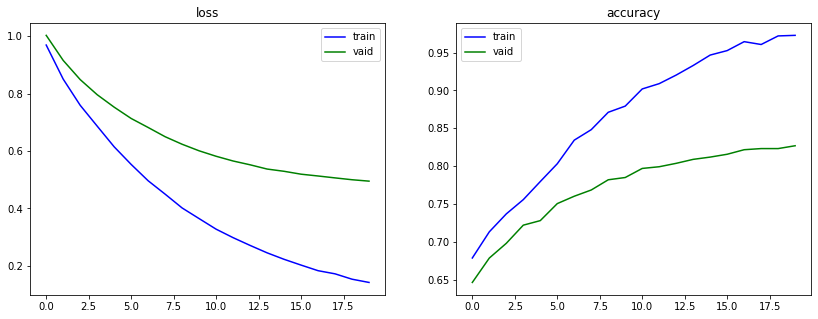

In [33]:
from torch.nn import functional as F

class CNN(nn.Module):
  def __init__(self, vocab_size, emb_size=300, output_size=4, out_channels=100, kernel_heights=3, stride=1, padding=1, padding_idx=0):
    super().__init__()
    self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
    self.conv = nn.Conv2d(1, out_channels, (kernel_heights, emb_size), stride, (padding, 0))
    self.drop = nn.Dropout(0.3)
    self.fc = nn.Linear(out_channels, output_size)

  def forward(self, x):
    x = self.emb(x).unsqueeze(1)
    x = self.conv(x)
    x = F.relu(x.squeeze(3))
    x = F.max_pool1d(x, x.size()[2])
    x = self.fc(self.drop(x.squeeze(2)))
    return x

# モデルの定義
model = CNN(vocab_size, padding_idx=padding_idx).to(device)
# 損失関数
criterion = nn.CrossEntropyLoss()
# オプティマイザ
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

train_losses = [] # 学習データの損失
train_accuracies = [] # 学習データの正解率
valid_losses = [] # 検証データの損失
valid_accuracies = [] # 検証データの正解率


for epoch in range(20):
    for data in loader:
        # デバイスの指定
        inputs = data['inputs'].to(device)
        labels = data['labels'].to(device)
        # forward
        model.train()
        outputs = model(inputs.to(device))
        # 損失
        loss = criterion(outputs, labels).to(device)
        # 勾配
        optimizer.zero_grad()
        loss.backward()
        # 更新
        optimizer.step()

    # 学習の進捗
    train_loss, train_accuracy = loss_and_accuracy(model, train_dataset, device, criterion=criterion)
    valid_loss, valid_accuracy = loss_and_accuracy(model, valid_dataset, device, criterion=criterion)

    # 保存
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_accuracy)

    # グラフの描画
    live_plot(train_losses, train_accuracies, valid_losses, valid_accuracies)

## 88. パラメータチューニング
***
問題85や問題87のコードを改変し，ニューラルネットワークの形状やハイパーパラメータを調整しながら，高性能なカテゴリ分類器を構築せよ．

In [23]:
from torch.nn import functional as F
from torch.nn import functional as F
class CNN_opt(nn.Module):
    def __init__(self, vocab_size, padding_idx, fc_num_layer, out_channels, drop_rate, 
                output_size=4, kernel_heights=3, emb_size=300):
        super().__init__()
        # 第１層
        self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
        # 第２層
        self.conv = nn.Conv2d(1, out_channels[0], (kernel_heights, emb_size), 1, (1, 0))
        # 3層目以降
        self.fcs = nn.ModuleList()
        self.drop = nn.Dropout(drop_rate)
        for i in range(1, fc_num_layer+2):
            self.fcs.append(nn.Linear(out_channels[i-1], out_channels[i]))

    
    def forward(self, x):
        x = self.emb(x).unsqueeze(1)
        x = self.conv(x)
        x = F.relu(x.squeeze(3))
        x = F.max_pool1d(x, x.size()[2]).squeeze(2)
        for fc in self.fcs:
            x = fc(self.drop(x))
        return x

In [24]:
import optuna

import torch.optim as optim

def objective(trial):
    # チューニング対象パラメータのセット
    #畳込み層の数のパラメータ
    fc_num_layer = trial.suggest_int("fc_num_layer", 0, 5)
    out_channels = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 50, 200, 50)) for i in range(fc_num_layer+1)] + [4] # hidden_param + output_size
    drop_rate = trial.suggest_discrete_uniform('drop_rate', 0.0, 0.5, 0.1)
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
    batch_size = int(trial.suggest_discrete_uniform('batch_size', 2, 16, 32))
    #optimizer
    optimizer_name = trial.suggest_categorical("optimizer", ["sgd", "adam"])

    # 固定パラメータの設定
    vocab_size = len(word_dict.keys())+1 # 辞書のID数 + パディングID
    padding_idx = len(word_dict.keys()) # 最終番号をパディング値とする
    num_epochs = 20

    # モデルの定義
    model = CNN_opt(vocab_size, padding_idx, fc_num_layer, out_channels, drop_rate).to(device)

    # 損失関数の定義
    criterion = nn.CrossEntropyLoss()

    # オプティマイザの定義
    if optimizer_name == "sgd":
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    elif optimizer_name == "adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    
    # モデルの学習
    for epoch in range(num_epochs):
        for data in loader:
            # デバイスの指定
            inputs = data['inputs'].to(device)
            labels = data['labels'].to(device)
            # forward
            model.train()
            outputs = model(inputs.to(device))
            # 損失
            loss = criterion(outputs, labels).to(device)
            # 勾配
            optimizer.zero_grad()
            loss.backward()
            # 更新
            optimizer.step()

    valid_loss, valid_accuracy = loss_and_accuracy(model, valid_dataset, device, criterion=criterion)

    return valid_loss 

In [25]:
# 最適化
study = optuna.create_study()
study.optimize(objective, timeout=7200)

[I 2022-05-29 04:45:59,289] A new study created in memory with name: no-name-4ac77e54-9b76-45dd-bce2-657362cfb710
/usr/local/lib/python3.7/site-packages/optuna/distributions.py:548: UserWarning: The distribution is specified by [2, 16] and q=32, but the range is not divisible by `q`. It will be replaced by [2, 2.0].
  low=low, old_high=old_high, high=high, step=q
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
[I 2022-05-29 04:49:45,084] Trial 0 finished with value: 1.0401620420067386 and parameters: {'fc_num_layer': 2, 'num_filter_0': 50.0, 'num_filter_1': 150.0, 'num_filter_2': 150.0, 'drop_rate': 0.0, 'lr': 1.804867318741272e-05, 'batch_size': 2.0, 'optimizer': 'sgd'}. Best is trial 0 with value: 1.0401620420067386.
/usr/local/lib/python3.7/site-packages/optuna/distribution

In [26]:
# 結果
print('best value',study.best_value)
print('params',study.best_params)

best value 0.46038509510860315
params {'fc_num_layer': 0, 'num_filter_0': 100.0, 'drop_rate': 0.4, 'lr': 0.0013390727119242613, 'batch_size': 2.0, 'optimizer': 'sgd'}


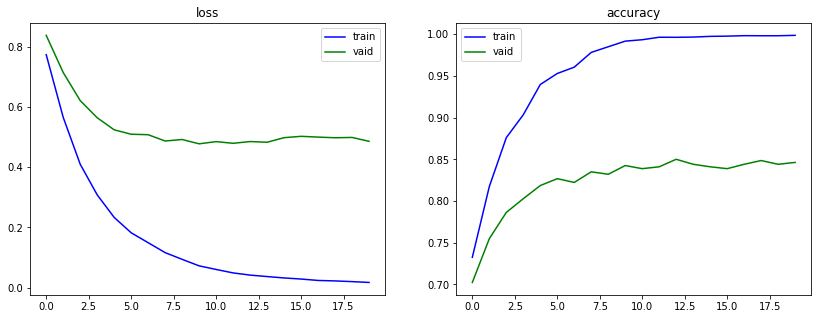

In [32]:
# best hyperparams
fc_num_layer = int(study.best_params['fc_num_layer'])
out_channels = [int(study.best_params['num_filter_0'])] + [4]
drop_rate = study.best_params['drop_rate']
lr = study.best_params['lr']
batch_size = int(study.best_params['batch_size'])
# モデルの定義
model = CNN_opt(vocab_size, padding_idx, fc_num_layer, out_channels, drop_rate).to(device)
#optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

train_losses = [] # 学習データの損失
train_accuracies = [] # 学習データの正解率
valid_losses = [] # 検証データの損失
valid_accuracies = [] # 検証データの正解率

loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# モデルの学習
for epoch in range(20):
    for data in loader:
        # デバイスの指定
        inputs = data['inputs'].to(device)
        labels = data['labels'].to(device)
        # forward
        model.train()
        outputs = model(inputs.to(device))
        # 損失
        loss = criterion(outputs, labels).to(device)
        # 勾配
        optimizer.zero_grad()
        loss.backward()
        # 更新
        optimizer.step()

    # 学習の進捗
    train_loss, train_accuracy = loss_and_accuracy(model, train_dataset, device, criterion=criterion)
    valid_loss, valid_accuracy = loss_and_accuracy(model, valid_dataset, device, criterion=criterion)

    # 保存
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_accuracy)

    # グラフの描画
    live_plot(train_losses, train_accuracies, valid_losses, valid_accuracies)

# 損失の算出
valid_loss, valid_accuracy = loss_and_accuracy(model, valid_dataset, device, criterion=criterion)

## 89. 事前学習済み言語モデルからの転移学習
***
事前学習済み言語モデル（例えばBERTなど）を出発点として，ニュース記事見出しをカテゴリに分類するモデルを構築せよ．

In [6]:
from transformers import BertTokenizer, BertModel, BertForSequenceClassification
import pytorch_lightning as pl
model_name = 'bert-base-cased-finetuned-mrpc'
tokenizer = BertTokenizer.from_pretrained(model_name)

[Pytorch Lightningを使用したBERT文書分類モデルの実装](https://qiita.com/tchih11/items/7e97db29b95cf08fdda0)

In [7]:
from torch.utils.data import DataLoader, Dataset
class BertDataset(Dataset):
    """
    DataFrameを下記のitemを保持するDatasetに変換。
    text(原文)、input_ids(tokenizeされた文章)、attention_mask、labels(ラベル)
    """

    def __init__(self, data, tokenizer, max_len):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        data_row = self.data.iloc[index]
        text = data_row['title']
        category_dict = {'b': 0, 'e': 1, 't':2, 'm':3}
        labels = torch.tensor(category_dict[data_row['category']])

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return dict(
            text=text,
            input_ids=encoding["input_ids"].flatten(),
            attention_mask=encoding["attention_mask"].flatten(),
            labels=labels
        )

class CreateDataModule(pl.LightningDataModule):
    """
    DataFrameからモデリング時に使用するDataModuleを作成
    """
    def __init__(self, train_df, valid_df, test_df, batch_size=16, pretrained_model='bert-base-cased-finetuned-mrpc'):
        super().__init__()
        self.train_df = train_df
        self.valid_df = valid_df
        self.test_df = test_df
        self.batch_size = batch_size
        self.max_len = train_df['title'].str.len().max()
        self.tokenizer = BertTokenizer.from_pretrained(pretrained_model)

    def setup(self, stage=None):
        self.train_dataset = BertDataset(self.train_df, self.tokenizer, self.max_len)
        self.vaild_dataset = BertDataset(self.valid_df, self.tokenizer, self.max_len)
        self.test_dataset = BertDataset(self.test_df, self.tokenizer, self.max_len)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.vaild_dataset, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size)


In [8]:
# 作ったDataFrameを渡してsetup
data_module = CreateDataModule(train,valid,test)
data_module.setup()

In [10]:
class TextClassifier(pl.LightningModule):
    def __init__(self, n_classes: int, n_epochs=None, 
                 pretrained_model='bert-base-cased-finetuned-mrpc'):
        super().__init__()

        # モデルの構造
        self.bert = BertModel.from_pretrained(
            pretrained_model, return_dict=True)
        self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)
        self.n_epochs = n_epochs
        self.criterion = nn.CrossEntropyLoss()

        # BertLayerモジュールの最後を勾配計算ありに変更
        for param in self.bert.parameters():
            param.requires_grad = False
        for param in self.bert.encoder.layer[-1].parameters():
            param.requires_grad = True

    # 順伝搬 nn.Moduleのforwardと同じ. 主に予測で使用する。
    def forward(self, input_ids, attention_mask, labels=None):
        output = self.bert(input_ids, attention_mask=attention_mask)
        preds = self.classifier(output.pooler_output)
        loss = 0
        if labels is not None:
            loss = self.criterion(preds, labels)
        return loss, preds

    # trainのミニバッチに対して行う処理
    def training_step(self, batch, batch_idx):
        loss, preds = self.forward(input_ids=batch["input_ids"],
                                    attention_mask=batch["attention_mask"],
                                    labels=batch["labels"])
        return {'loss': loss,
                'batch_preds': preds,
                'batch_labels': batch["labels"]}

    # validation、testでもtrain_stepと同じ処理を行う
    def validation_step(self, batch, batch_idx):
        loss, preds = self.forward(input_ids=batch["input_ids"],
                                    attention_mask=batch["attention_mask"],
                                    labels=batch["labels"])
        return {'loss': loss,
                'batch_preds': preds,
                'batch_labels': batch["labels"]}

    def test_step(self, batch, batch_idx):
        loss, preds = self.forward(input_ids=batch["input_ids"],
                                    attention_mask=batch["attention_mask"],
                                    labels=batch["labels"])
        return {'loss': loss,
                'batch_preds': preds,
                'batch_labels': batch["labels"]}

    # epoch終了時にvalidationのlossとaccuracyを記録
    def validation_epoch_end(self, outputs, mode="val"):
        # loss計算
        epoch_preds = torch.cat([x['batch_preds'] for x in outputs])
        epoch_labels = torch.cat([x['batch_labels'] for x in outputs])
        epoch_loss = self.criterion(epoch_preds, epoch_labels)
        self.log(f"{mode}_loss", epoch_loss, logger=True)

        # accuracy計算
        num_correct = (epoch_preds.argmax(dim=1) == epoch_labels).sum().item()
        epoch_accuracy = num_correct / len(epoch_labels)
        self.log(f"{mode}_accuracy", epoch_accuracy, logger=True)

    # testデータのlossとaccuracyを算出（validationの使いまわし）
    # test epoch終了ごとに呼び出される
    def test_epoch_end(self, outputs):
        return self.validation_epoch_end(outputs, "test")

    # optimizerの設定
    def configure_optimizers(self):
        # pretrainされているbert最終層のlrは小さめ、pretrainされていない分類層のlrは大きめに設定
        optimizer = optim.Adam([
            {'params': self.bert.encoder.layer[-1].parameters(), 'lr': 5e-5},
            {'params': self.classifier.parameters(), 'lr': 1e-4}
        ])

        return [optimizer]

In [19]:
# epoch数
N_EPOCHS = 10

# モデルインスタンスを作成
model = TextClassifier(n_classes=4,n_epochs=N_EPOCHS)

# EarlyStoppingの設定
# 3epochで'val_loss'が0.05以上減少しなければ学習をストップ
early_stop_callback = EarlyStopping(
    monitor='val_loss', 
    min_delta=0.05, 
    patience=3, 
    mode='min')

# モデルの保存先
# epoch数に応じて、「epoch=0.ckpt」のような形で指定したディレクトリに保存される
checkpoint_callback = ModelCheckpoint(
    dirpath="./checkpoints",
    filename='{epoch}',
    verbose=True,
    monitor='val_loss',
    mode='min'
)

# Trainerに設定
trainer = pl.Trainer(max_epochs=N_EPOCHS,
                     gpus=1,
                     accelerator="gpu",
                     progress_bar_refresh_rate=30,
                    #  callbacks=[early_stop_callback])
                     callbacks=[checkpoint_callback, early_stop_callback])

Some weights of the model checkpoint at bert-base-cased-finetuned-mrpc were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:97: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=30)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the 

In [20]:
# 学習
trainer.fit(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type             | Params
------------------------------------------------
0 | bert       | BertModel        | 108 M 
1 | classifier | Linear           | 3.1 K 
2 | criterion  | CrossEntropyLoss | 0     
------------------------------------------------
7.1 M     Trainable params
101 M     Non-trainable params
108 M     Total params
433.253   Total estimated model params size (MB)


/usr/local/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:245: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 96 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,
/usr/local/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:245: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 96 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


Epoch 0: 100%|██████████| 751/751 [00:19<00:00, 37.76it/s, loss=0.475, v_num=1]

Epoch 0, global step 667: 'val_loss' reached 0.40353 (best 0.40353), saving model to '/workspace/NLP100knock/checkpoints/epoch=0.ckpt' as top 1


Epoch 1: 100%|██████████| 751/751 [00:19<00:00, 38.57it/s, loss=0.336, v_num=1]

Epoch 1, global step 1334: 'val_loss' reached 0.29050 (best 0.29050), saving model to '/workspace/NLP100knock/checkpoints/epoch=1.ckpt' as top 1


Epoch 2: 100%|██████████| 751/751 [00:19<00:00, 38.73it/s, loss=0.277, v_num=1]

Epoch 2, global step 2001: 'val_loss' reached 0.28822 (best 0.28822), saving model to '/workspace/NLP100knock/checkpoints/epoch=2.ckpt' as top 1


Epoch 3: 100%|██████████| 751/751 [00:19<00:00, 38.68it/s, loss=0.251, v_num=1]

Epoch 3, global step 2668: 'val_loss' was not in top 1


Epoch 4: 100%|██████████| 751/751 [00:19<00:00, 38.77it/s, loss=0.232, v_num=1]

Epoch 4, global step 3335: 'val_loss' reached 0.28447 (best 0.28447), saving model to '/workspace/NLP100knock/checkpoints/epoch=4.ckpt' as top 1


Epoch 4: 100%|██████████| 751/751 [00:19<00:00, 37.63it/s, loss=0.232, v_num=1]


In [34]:
trainer.test(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:245: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 96 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


Testing DataLoader 0: 100%|██████████| 84/84 [00:01<00:00, 57.54it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.9025487303733826
        test_loss           0.2871730327606201
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.2871730327606201, 'test_accuracy': 0.9025487303733826}]

In [36]:
%reload_ext tensorboard

In [16]:
%reload_ext tensorboard